In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics,tree
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv('test.csv')
meal=pd.read_csv("meal_info.csv")
center=pd.read_csv('fulfilment_center_info.csv')

In [3]:
print("The Shape of training data set:",train.shape)
print("The Shape of testing data set:",test.shape)
print("The Shape of meal information:",meal.shape)
print("The Shape of Fulfilment Center information",center.shape)

The Shape of training data set: (456548, 9)
The Shape of testing data set: (32573, 8)
The Shape of meal information: (51, 3)
The Shape of Fulfilment Center information (77, 5)


In [4]:
display(train.head())
display(test.head())
display(meal.head())
display(center.head())

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


#### Checking missing values

In [5]:
print("The missing values in training dataset :",train.isnull().sum().sum())
print("The missing values in testing dataset :",test.isnull().sum().sum())
print("The missing values in meal information :",meal.isnull().sum().sum())
print("The missing values in Fulfillment center information :",center.isnull().sum().sum())

The missing values in training dataset : 0
The missing values in testing dataset : 0
The missing values in meal information : 0
The missing values in Fulfillment center information : 0


Observation: There is no missing values in any data set and information provided

In [6]:
print("There are",center["center_id"].nunique(),"warehouse spread across",center["city_code"].nunique()\
      ,"Cities and",center["region_code"].nunique(),"Regions for the company.")
print("The company has",meal["meal_id"].nunique(),"unique meals, divided into",meal["category"].nunique(),\
      "categories and",meal["cuisine"].nunique(),"cuisine.")

There are 77 warehouse spread across 51 Cities and 8 Regions for the company.
The company has 51 unique meals, divided into 14 categories and 4 cuisine.


In [7]:
#Merge train data with meal and center info
train_meal = pd.merge(train, meal, on="meal_id", how="left")
train_total = pd.merge(train_meal, center, on="center_id", how="left")
print("Shape of train data : ", train_total.shape)
display(train_total.head())

#Merge test data with meal and center info
test_meal= pd.merge(test, meal, on="meal_id", how="outer")
test_total = pd.merge(test_meal, center, on="center_id", how="outer")
print("Shape of test data : ", test_total.shape)
display(test_total.head())

Shape of train data :  (456548, 15)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


Shape of test data :  (32573, 14)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0


In [8]:
display(train_total.info())
display(test_total.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
 8   category               32573 non-null  object 
 9   cuisine                32573 non-null  object 
 10  city_code              32573 non-null  int64  
 11  region_code            32573 non-null  int64  
 12  center_type            32573 non-null  object 
 13  op_area                32573 non-null  float64
dtypes: float64(3), int64(8), object(3)
memory usage: 3.7+ 

None

In [9]:
display(train_total.describe().T)
display(test_total.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00
city_code,456548.0,6.015534e+02,66.195914,456.00,553.00,596.00,651.00,713.00


,count,mean,std,min,25%,50%,75%,max
id,32573.0,1.248476e+06,144158.048324,1000085.00,1123969.00,1247296.00,1372971.00,1499996.00
week,32573.0,1.504778e+02,2.864072,146.00,148.00,150.00,153.00,155.00
center_id,32573.0,8.190173e+01,45.950455,10.00,43.00,76.00,110.00,186.00
meal_id,32573.0,2.032068e+03,547.199004,1062.00,1558.00,1993.00,2569.00,2956.00
checkout_price,32573.0,3.418544e+02,153.893886,67.90,214.43,320.13,446.23,1113.62
base_price,32573.0,3.564936e+02,155.150101,89.24,243.50,321.13,455.93,1112.62
emailer_for_promotion,32573.0,6.643539e-02,0.249045,0.00,0.00,0.00,0.00,1.00
homepage_featured,32573.0,8.135572e-02,0.273385,0.00,0.00,0.00,0.00,1.00
city_code,32573.0,6.015200e+02,65.996677,456.00,556.00,596.00,651.00,713.00
region_code,32573.0,5.671215e+01,17.641174,23.00,34.00,56.00,77.00,93.00


,center_id,num_orders
2,13,4296545
18,43,3920294
0,10,3381018
21,52,3125835
63,137,3117478
31,67,2839493
1,11,2797300
74,174,2792587
53,104,2427542
9,27,2297698


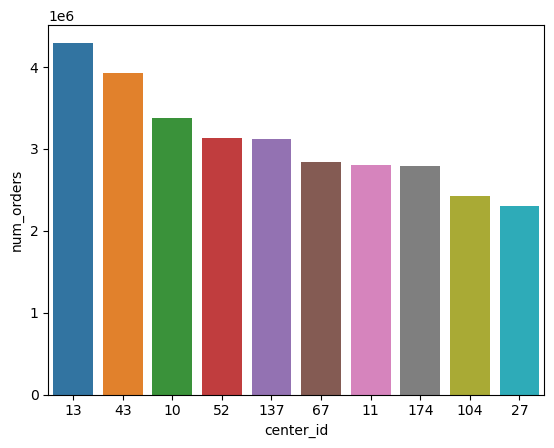

In [10]:
center_order=train_total.groupby("center_id",as_index=False).sum()
center_orders=center_order[["center_id","num_orders"]].sort_values(by="num_orders",ascending=False).head(10)
display(center_orders)
sns.barplot(x=center_orders["center_id"].astype("str"),y=center_orders["num_orders"]);

,cuisine,num_orders
2,Italian,44172832
3,Thai,32677670
1,Indian,25792544
0,Continental,16914439


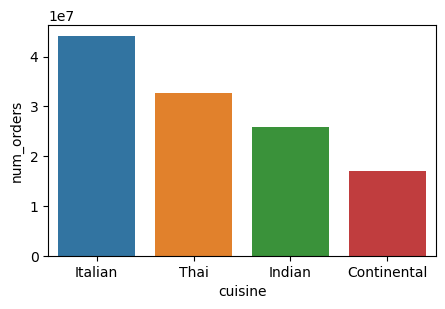

In [11]:
cuisine_order=train_total.groupby("cuisine",as_index=False).sum()
cuisine_orders=cuisine_order[["cuisine","num_orders"]].sort_values(by="num_orders",ascending=False).head(10)
display(cuisine_orders)
plt.figure(figsize=(5,3))
sns.barplot(x="cuisine",y="num_orders",data=train_total,estimator=np.sum,ci=None,
            order=cuisine_orders.sort_values('num_orders',ascending = False).cuisine)
plt.show();

,center_type,num_orders
0,TYPE_A,68978517
1,TYPE_B,29996073
2,TYPE_C,20582895


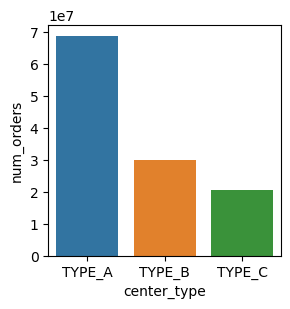

In [12]:
center_typeorder=train_total.groupby("center_type",as_index=False).sum()
center_typeorders=center_typeorder[["center_type","num_orders"]].sort_values(by="num_orders",ascending=False).head(10)
display(center_typeorders)
plt.figure(figsize=(3,3))
sns.barplot(x="center_type",y="num_orders",data=train_total,estimator=np.sum,ci=None,
           order=center_typeorders.sort_values('num_orders',ascending = False).center_type)
plt.show();

,category,num_orders
0,Beverages,40480525
8,Rice Bowl,20874063
10,Sandwich,17636782
9,Salad,10944336
7,Pizza,7383720
5,Other Snacks,4766293
13,Starters,4649122
3,Extras,3984979
11,Seafood,2715714
2,Desert,1940754


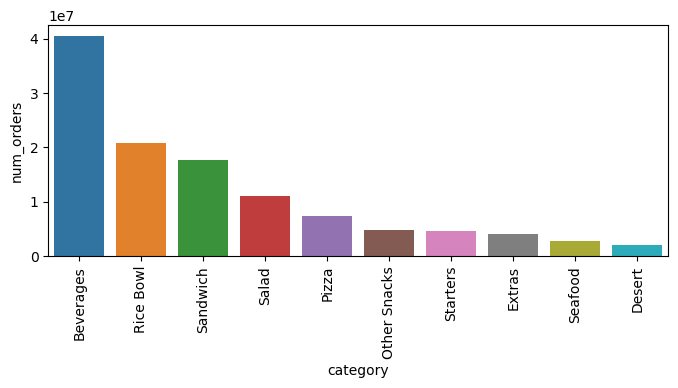

In [13]:
category_order=train_total.groupby("category",as_index=False).sum()
category_orders=category_order[["category","num_orders"]].sort_values(by="num_orders",ascending=False).head(10)
display(category_orders)
plt.figure(figsize=(8,3))
sns.barplot(x="category",y="num_orders",data=train_total,estimator=np.sum,ci=None,
           order=category_orders.sort_values('num_orders',ascending = False).category)
plt.xticks(rotation=90)
plt.show();

     week  num_orders
47     48     1303457
4       5     1198675
59     60     1131459
52     53     1108236
99    100     1088162
68     69     1075188
108   109     1068318
51     52     1046811
31     32     1034202
70     71     1015726


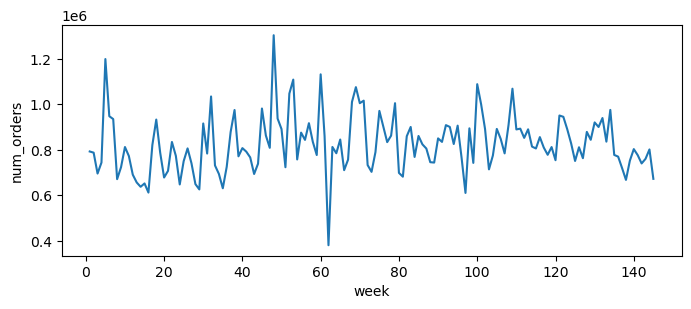

In [14]:
week_order=train_total.groupby("week",as_index=False).sum()
week_orders=week_order[["week","num_orders"]].sort_values(by="num_orders",ascending=False)
print(week_orders.head(10))
plt.figure(figsize=(8,3))
sns.lineplot(x="week",y="num_orders",data=week_orders,markers=True,estimator=np.sum)
plt.show();

Observation:
1. Center id (13,43) are contributing the most of the orders.
3. Beverages are ordered by the customers more followed by rice and sandwich.
4. Italian foods maximum order by customers followed by Thai.
5. Type A center type are maximum where orders are being placed.
6. Week 48 is contributing highest amoung orders.There is no seasonality shown in data.Lowest order placed in week 62.

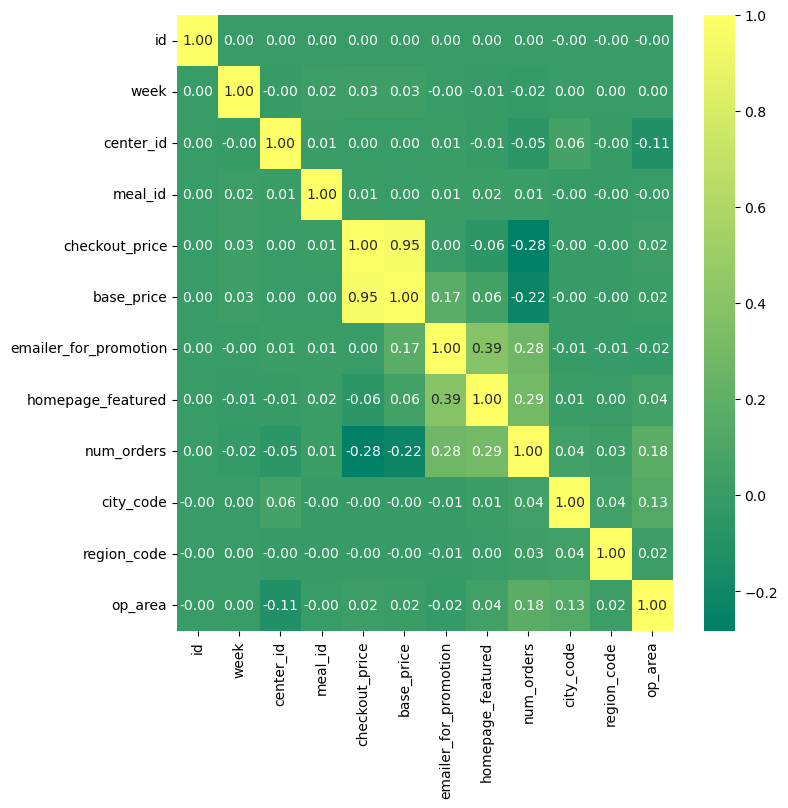

In [15]:
plt.figure(figsize=(8,8))
sns.heatmap(train_total.corr(),annot=True,fmt='.2f',cmap='summer')
plt.show()

Observations:
1. High correlation between base_price and checkout_price. So one of them can be dropped for further analysis.
2. ID is irrelevant for further analysis so it can be dropped.
3. Checkout price is negatively correlated with num_orders as per the bar.

In [16]:
train_total=train_total.drop(['id','checkout_price'],axis=1)

In [17]:
for feature in train_total.columns: 
    if train_total[feature].dtype == 'object':
        print(train_total[feature].value_counts(),'\n')

Beverages       127890
Rice Bowl        33408
Sandwich         33291
Pizza            33138
Starters         29941
Other Snacks     29379
Desert           29294
Salad            28559
Pasta            27694
Seafood          26916
Biryani          20614
Extras           13562
Soup             12675
Fish             10187
Name: category, dtype: int64 

Italian        122925
Thai           118216
Indian         112612
Continental    102795
Name: cuisine, dtype: int64 

TYPE_A    262881
TYPE_C     99593
TYPE_B     94074
Name: center_type, dtype: int64 



In [18]:
train_total['category'] = np.where(train_total['category'] == 'Beverages','0',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Rice Bowl','1',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Sandwich','2',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Pizza','3',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Starters','4',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Other Snacks','5',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Desert','6',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Salad','7',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Pasta','8',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Seafood','9',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Biryani','10',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Extras','11',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Soup','12',train_total['category'])
train_total['category'] = np.where(train_total['category'] == 'Fish','13',train_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Beverages','0',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Rice Bowl','1',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Sandwich','2',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Pizza','3',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Starters','4',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Other Snacks','5',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Desert','6',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Salad','7',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Pasta','8',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Seafood','9',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Biryani','10',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Extras','11',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Soup','12',test_total['category'])
test_total['category'] = np.where(test_total['category'] == 'Fish','13',test_total['category'])
train_total['category'] = train_total['category'].astype('int64')
test_total['category'] = train_total['category'].astype('int64')

In [19]:
train_total['cuisine'] = np.where(train_total['cuisine'] == 'Italian','0',train_total['cuisine'])
train_total['cuisine'] = np.where(train_total['cuisine'] == 'Thai','1',train_total['cuisine'])
train_total['cuisine'] = np.where(train_total['cuisine'] == 'Indian','2',train_total['cuisine'])
train_total['cuisine'] = np.where(train_total['cuisine'] == 'Continental','3',train_total['cuisine'])
test_total['cuisine'] = np.where(test_total['cuisine'] == 'Italian','0',test_total['cuisine'])
test_total['cuisine'] = np.where(test_total['cuisine'] == 'Thai','1',test_total['cuisine'])
test_total['cuisine'] = np.where(test_total['cuisine'] == 'Indian','2',test_total['cuisine'])
test_total['cuisine'] = np.where(test_total['cuisine'] == 'Continental','3',test_total['cuisine'])
train_total['cuisine'] = train_total['cuisine'].astype('int64')
test_total['cuisine'] = test_total['cuisine'].astype('int64')

In [20]:
train_total['center_type'] = np.where(train_total['center_type'] == 'TYPE_A','0',train_total['center_type'])
train_total['center_type'] = np.where(train_total['center_type'] == 'TYPE_B','1',train_total['center_type'])
train_total['center_type'] = np.where(train_total['center_type'] == 'TYPE_C','2',train_total['center_type'])
test_total['center_type'] = np.where(test_total['center_type'] == 'TYPE_A','0',test_total['center_type'])
test_total['center_type'] = np.where(test_total['center_type'] == 'TYPE_B','1',test_total['center_type'])
test_total['center_type'] = np.where(test_total['center_type'] == 'TYPE_C','2',test_total['center_type'])
train_total['center_type'] = train_total['center_type'].astype('int64')
test_total['center_type'] = test_total['center_type'].astype('int64')

In [21]:
display(train_total.head())
display(test_total.head())

,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,55,1885,152.29,0,0,177,0,1,647,56,2,2.0
1,1,55,1993,135.83,0,0,270,0,1,647,56,2,2.0
2,1,55,2539,135.86,0,0,189,0,1,647,56,2,2.0
3,1,55,2139,437.53,0,0,54,0,2,647,56,2,2.0
4,1,55,2631,242.50,0,0,40,0,2,647,56,2,2.0


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,0,1,647,56,2,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,0,1,647,56,2,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,0,1,647,56,2,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,0,1,647,56,2,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,0,1,647,56,2,2.0


RS=RobustScaler()
for features in train_total.columns:
    train_total[features]=RS.fit_transform(train_total[[features]])

In [22]:
display(train_total.head())
display(test_total.head())

,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,55,1885,152.29,0,0,177,0,1,647,56,2,2.0
1,1,55,1993,135.83,0,0,270,0,1,647,56,2,2.0
2,1,55,2539,135.86,0,0,189,0,1,647,56,2,2.0
3,1,55,2139,437.53,0,0,54,0,2,647,56,2,2.0
4,1,55,2631,242.50,0,0,40,0,2,647,56,2,2.0


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,0,1,647,56,2,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,0,1,647,56,2,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,0,1,647,56,2,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,0,1,647,56,2,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,0,1,647,56,2,2.0


In [23]:
train_total=np.sqrt(np.square(train_total))
X=train_total.drop('num_orders',axis=1)
train_mod = X.iloc[:322018,:]
train_value=train_total['num_orders'].head(322018)
test_mod  = X.iloc[322019:,:]
test_value=train_total['num_orders'].tail(134529)

In [24]:
(train_total<0).any().any()

False

In [25]:
display(train_mod.head())
display(test_mod.head())
display(train_value.head())
display(test_value.head())

,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1.0,55.0,1885.0,152.29,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
1,1.0,55.0,1993.0,135.83,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
2,1.0,55.0,2539.0,135.86,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
3,1.0,55.0,2139.0,437.53,0.0,0.0,0.0,2.0,647.0,56.0,2.0,2.0
4,1.0,55.0,2631.0,242.50,0.0,0.0,0.0,2.0,647.0,56.0,2.0,2.0


,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
322019,105.0,55.0,1993.0,152.35,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
322020,105.0,55.0,2539.0,148.47,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
322021,105.0,55.0,2139.0,292.03,0.0,0.0,0.0,2.0,647.0,56.0,2.0,2.0
322022,105.0,55.0,2631.0,154.26,0.0,0.0,0.0,2.0,647.0,56.0,2.0,2.0
322023,105.0,55.0,1248.0,153.26,0.0,0.0,0.0,2.0,647.0,56.0,2.0,2.0


0    177.0
1    270.0
2    189.0
3     54.0
4     40.0
Name: num_orders, dtype: float64

322019    202.0
322020    189.0
322021     26.0
322022    188.0
322023     68.0
Name: num_orders, dtype: float64

In [26]:
display(train_value.shape)
display(train_mod.shape)
display(test_value.shape)
display(test_mod.shape)

(322018,)

(322018, 12)

(134529,)

(134529, 12)

In [27]:
train_value.head()

0    177.0
1    270.0
2    189.0
3     54.0
4     40.0
Name: num_orders, dtype: float64

In [28]:
display((train_value<0).any().any())
display((test_value<0).any().any())

False

False

In [29]:
rfr=RandomForestRegressor(n_estimators=100,random_state=123)

RandomForestClassifier, DecisionTreeClassifier are the one which can be used for RMSLE value

In [30]:
rfr_model=rfr.fit(train_mod,train_value)

In [31]:
pred_train=rfr_model.predict(train_mod).round()
#pred_train=rfr.predict(train_mod)
#pred_train = np.argmax(rfr_model.predict(train_mod), axis=-1)
#pred_train
pred_test=rfr_model.predict(test_mod).round()
#pred_test=rfr.predict(test_mod)
#pred_test = np.argmax(rfr_model.predict(test_mod), axis=-1)
#pred_test.head()

In [32]:
print(classification_report(test_value,pred_test))

              precision    recall  f1-score   support

        13.0       1.00      0.00      0.00      3649
        14.0       0.21      0.01      0.01      3541
        15.0       0.22      0.01      0.03      3540
        16.0       0.00      0.00      0.00         0
        17.0       0.00      0.00      0.00         0
        18.0       0.00      0.00      0.00         0
        19.0       0.00      0.00      0.00         0
        20.0       0.00      0.00      0.00         0
        21.0       0.00      0.00      0.00         0
        22.0       0.00      0.00      0.00         0
        23.0       0.00      0.00      0.00         0
        24.0       0.00      0.00      0.00         0
        25.0       0.00      0.00      0.00         0
        26.0       0.07      0.02      0.03      3340
        27.0       0.08      0.02      0.04      3316
        28.0       0.10      0.02      0.04      3392
        29.0       0.00      0.00      0.00         0
        30.0       0.00    

In [33]:
print(confusion_matrix(test_value,pred_test))

[[ 1 22 52 ...  0  0  0]
 [ 0 24 55 ...  0  0  0]
 [ 0 22 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [34]:
RMSLE_train_score=np.sqrt(metrics.mean_squared_log_error(train_value,pred_train))
RMSLE_test_score=np.sqrt(metrics.mean_squared_log_error(test_value,pred_test))
display(RMSLE_train_score)
display(RMSLE_test_score)

0.22667900475056688

0.6756647230535289

In [35]:
RFR=pd.DataFrame({'Training Log Score':100*RMSLE_train_score,'Test Log Score':100*RMSLE_test_score},
            index=['Random Forest Regressor'])

In [36]:
DTR=tree.DecisionTreeRegressor(max_depth=5)

In [37]:
DTR_model=DTR.fit(train_mod,train_value)
pred_train_dtr=DTR_model.predict(train_mod)
pred_test_dtr=DTR_model.predict(test_mod)

In [38]:
RMSLE_train_score=np.sqrt(metrics.mean_squared_log_error(train_value,pred_train_dtr))
RMSLE_test_score=np.sqrt(metrics.mean_squared_log_error(test_value,pred_test_dtr))
display(RMSLE_train_score)
display(RMSLE_test_score)

0.8826922113297422

0.9153450752148522

In [39]:
DTR=pd.DataFrame({'Training Log Score':100*RMSLE_train_score,'Test Log Score':100*RMSLE_test_score},
            index=['Decision Tree Regressor'])

In [40]:
results = pd.concat([RFR, DTR])
results

,Training Log Score,Test Log Score
Random Forest Regressor,22.667900,67.566472
Decision Tree Regressor,88.269221,91.534508


As RMSLE is lowest in Random Forest so will be predict using Random Forest Model.

In [41]:
test_new=test_total.copy()
test_total=test_total.drop(['id','checkout_price'],axis=1)

SS=StandardScaler()
for features in test_total.columns:
    test_total[features]=SS.fit_transform(test_total[[features]])

In [42]:
test_total=np.sqrt(np.square(test_total))

In [43]:
test_total.head()

,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,146.0,55.0,1885.0,159.11,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
1,147.0,55.0,1885.0,159.11,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
2,149.0,55.0,1885.0,158.14,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
3,150.0,55.0,1885.0,157.14,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0
4,151.0,55.0,1885.0,159.11,0.0,0.0,0.0,1.0,647.0,56.0,2.0,2.0


In [44]:
test_final=test_total.copy()
pred=rfr_model.predict(test_final)
test_final['Number_of_Orders'] = pred

In [47]:
Demand = pd.DataFrame(columns=['id','center_id','category','cuisine','Number_of_orders'])
Demand['id']=test_new['id']
Demand['center_id']=test_new['center_id']
Demand['category']=test_new['category']
Demand['cuisine']=test_new['cuisine']
#test_final['Number_of_Orders']=SS.inverse_transform(test_final[['Number_of_Orders']])
Demand['Number_of_orders']=round(test_final['Number_of_Orders'],0)
Demand.head()
#Demand.to_csv('Prediction.csv')

,id,center_id,category,cuisine,Number_of_orders
0,1028232,55,0,1,263.0
1,1262649,55,0,1,263.0
2,1453211,55,0,1,272.0
3,1262599,55,0,1,274.0
4,1495848,55,0,1,263.0


In [48]:
Demand.to_csv('Prediction.csv')